Empezamos el proyecto en el que vamos a buscar un modelo bueno que nos permita detectar malos pagadores de un préstamo de crédito basándonos en el dataset HMEQ de Kaggle. Tras ello, haremos un sistema de scoring para traducir la fiabilidad de cada cliente a una puntuación numérica que nos permita identificar rápidamente la calidad crediticia de cada cliente. Finalmente, desarrollaremos un pequeño software que permita imputar datos de nuevos clientes y obtener directamente el scoring de cada uno de ellos, a modo de solución de software para ser usada desde un banco o similares.

IMPORTACIÓN LIBRERÍAS

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import joblib

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import (train_test_split, cross_val_predict,
                                    StratifiedKFold, GridSearchCV)
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (roc_auc_score, accuracy_score, confusion_matrix, 
                            roc_curve, precision_score, recall_score, f1_score,
                            fbeta_score, make_scorer)
from sklearn.feature_selection import SelectKBest

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC

from optbinning import BinningProcess
from optbinning.scorecard import Scorecard

IMPORTACIÓN DATASET

In [2]:
df = pd.read_csv('hmeq.csv')
print(df.shape)
df.head()

(5960, 13)


,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,1,1100,25860.0,39025.0,HomeImp,Other,10.5,0.0,0.0,94.366667,1.0,9.0,NaN
1,1,1300,70053.0,68400.0,HomeImp,Other,7.0,0.0,2.0,121.833333,0.0,14.0,NaN
2,1,1500,13500.0,16700.0,HomeImp,Other,4.0,0.0,0.0,149.466667,1.0,10.0,NaN
3,1,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,1700,97800.0,112000.0,HomeImp,Office,3.0,0.0,0.0,93.333333,0.0,14.0,NaN


# ANÁLISIS EDA

Primero de todo, sabemos que nuestro dataset tiene valores missing, así que vamos a convertirlos a valores NaN de pandas para garantizar que los tengamos en cuenta correctamente a la hora de realizar el estudio estadístico de nuestras variables.

In [3]:
df = df.replace('', pd.NA)

Ahora vamos a ver qué porcentaje de missing values tiene cada observación. Si una observación tiene más del 50% de sus valores como missing, la consideraremos candidata a eliminarla ya que no aporta la suficiente información como para ser útil.

In [4]:
pct_missings_rows = df.isna().mean(axis=1)
missing_over_50pct = (pct_missings_rows > 0.5).sum()
print(f'Hay {missing_over_50pct} filas con más del 50% de datos missing')

Hay 126 filas con más del 50% de datos missing


Vemos que sólo hay 126 filas con más del 50% de datos missing. Como es un número reducido respecto al total, podemos eliminarlas ya que seguimos teniendo suficientes observaciones en el dataset.

In [5]:
df = df.loc[pct_missings_rows <= 0.5]

DESCRIPCIÓN DE VARIABLES:
- BAD: 1 = cliente incumplió el préstamo, 0 = préstamo pagado
- LOAN: cantidad de préstamo
- MORTDUE: cantidad de hipoteca restante
- VALUE: valor de la propiedad
- REASON: DebtCon = consolidación de deuda, HomeImp = mejora de la vivienda
- JOB: ocupación (6 categorías)
- YOJ: años en el trabajo actual
- DEROG: número de informes negativos
- DELINQ: número de créditos impagados
- CLAGE: antigüedad del préstamo más antiguo en meses
- NINQ: número de líneas de crédito recientes
- CLNO: número de líneas de crédito
- DEBTINC: ratio deuda/salario

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5834 entries, 0 to 5959
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   BAD      5834 non-null   int64  
 1   LOAN     5834 non-null   int64  
 2   MORTDUE  5393 non-null   float64
 3   VALUE    5739 non-null   float64
 4   REASON   5667 non-null   object 
 5   JOB      5660 non-null   object 
 6   YOJ      5426 non-null   float64
 7   DEROG    5252 non-null   float64
 8   DELINQ   5380 non-null   float64
 9   CLAGE    5652 non-null   float64
 10  NINQ     5450 non-null   float64
 11  CLNO     5738 non-null   float64
 12  DEBTINC  4606 non-null   float64
dtypes: float64(9), int64(2), object(2)
memory usage: 638.1+ KB


Todas las variables tienen el tipo correcto. Todas son de tipo numérico excepto REASON y JOB, que son de tipo categórico.

IDENTIFICACIÓN DE LA VARIABLE OBJETIVO:

La variable objetivo es BAD, que es la que nos dice si un cliente cometió impago (BAD=1) o no (BAD=0). Vamos a ver qué porcentaje de las observaciones tienen el valor 1.

BAD
0    4673
1    1161
Name: count, dtype: int64
BAD
0    0.800994
1    0.199006
Name: proportion, dtype: float64


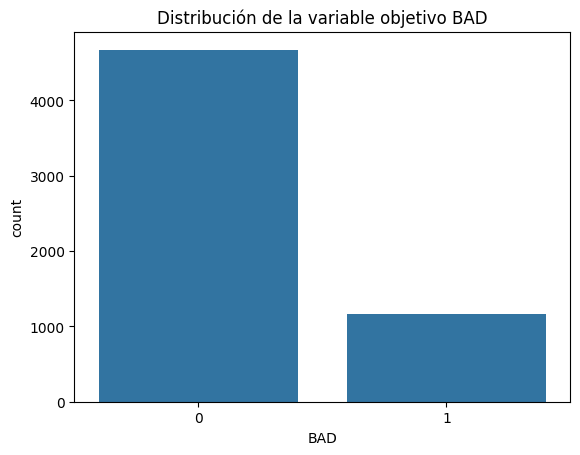

In [7]:
print(df['BAD'].value_counts())
print(df['BAD'].value_counts(normalize=True))

sns.countplot(x='BAD', data=df)
plt.title('Distribución de la variable objetivo BAD')
plt.show()

Tenemos un 20% de clientes que cometieron impago.

ANÁLISIS VALORES DE VARIABLES:

In [8]:
var = list(df.columns)
numeric_var = list(df.select_dtypes(include=['int64','float64']).columns)
categ_var = [var for var in var if var not in numeric_var]
numeric_var.remove('BAD')

In [9]:
# Estadísticos variables numéricas
df.describe()


,BAD,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
count,5834.000000,5834.000000,5393.000000,5739.000000,5426.000000,5252.000000,5380.000000,5652.000000,5450.000000,5738.000000,4606.000000
mean,0.199006,18724.494344,73897.201780,102106.123286,8.914062,0.254570,0.449442,179.766275,1.186055,21.296096,33.896005
std,0.399287,11257.210956,44539.074735,57635.358066,7.572245,0.846047,1.127266,85.810092,1.728675,10.138933,8.543100
min,0.000000,1100.000000,2063.000000,8000.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.524499
25%,0.000000,11200.000000,46380.000000,66208.500000,3.000000,0.000000,0.000000,115.116702,0.000000,15.000000,29.237047
50%,0.000000,16400.000000,65030.000000,89609.000000,7.000000,0.000000,0.000000,173.466667,1.000000,20.000000,34.888239
75%,0.000000,23500.000000,91683.000000,119798.500000,13.000000,0.000000,0.000000,231.562278,2.000000,26.000000,39.076554
max,1.000000,89900.000000,399550.000000,855909.000000,41.000000,10.000000,15.000000,1168.233561,17.000000,71.000000,203.312149


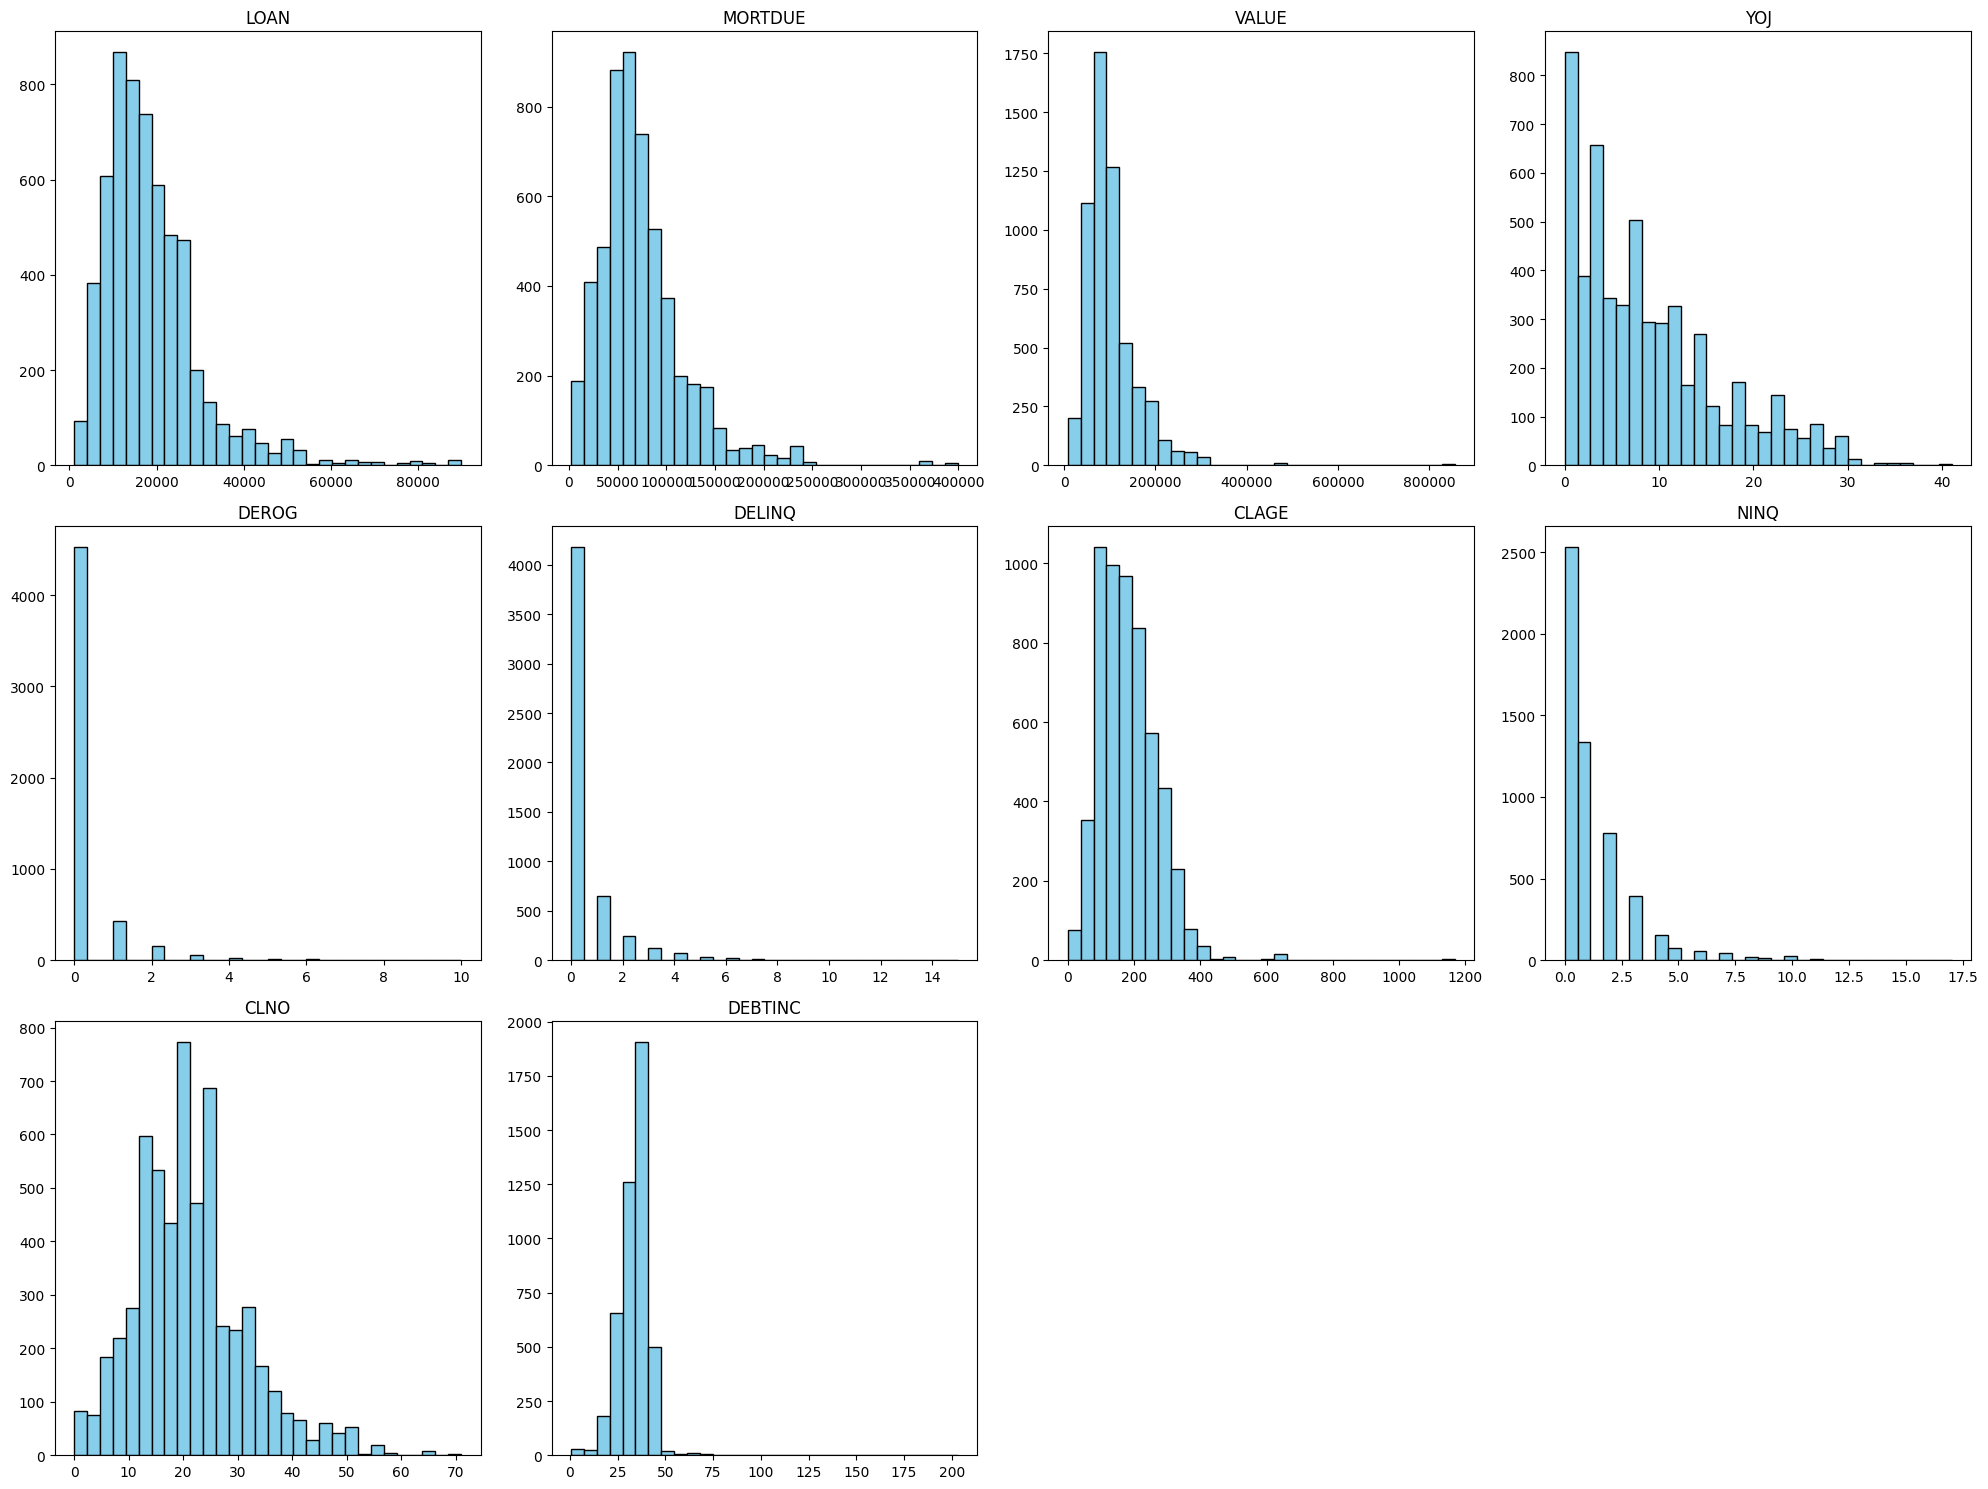

In [10]:
# Número de columnas numéricas
n = len(numeric_var)

n_cols = 4
n_rows = (n + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5*n_rows))
axes = axes.flatten()

# Iteramos sobre cada columna numérica
for i, col in enumerate(numeric_var):
    axes[i].hist(df[col].dropna(), bins=30, color="skyblue", edgecolor="black")
    axes[i].set_title(col)

# Para ocultar los gráficos vacíos que "sobran"
for j in range(i+1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

In [11]:
# Estadísticas variables categóricas
print(df['REASON'].value_counts(normalize=True, dropna=False))
print(df['JOB'].value_counts(normalize=True, dropna=False))

REASON
DebtCon    0.670895
HomeImp    0.300480
NaN        0.028625
Name: proportion, dtype: float64
JOB
Other      0.406925
ProfExe    0.218375
Office     0.161981
Mgr        0.131128
Self       0.033082
NaN        0.029825
Sales      0.018684
Name: proportion, dtype: float64


MISSINGS:

Vamos a mirar cuántos missing tiene cada variable y qué porcentaje representan. Más adelante decidiremos cómo tratamos a estos datos.

In [12]:
missings = df.isna().sum()
missings_rate = df.isna().mean()*100

missing_df = pd.DataFrame({
    'Missing_Count': missings,
    'Missing_Percent': missings_rate
})
missing_df

,Missing_Count,Missing_Percent
BAD,0,0.000000
LOAN,0,0.000000
MORTDUE,441,7.559136
VALUE,95,1.628385
REASON,167,2.862530
JOB,174,2.982516
YOJ,408,6.993486
DEROG,582,9.976003
DELINQ,454,7.781968
CLAGE,182,3.119643


ATÍPICOS:

Observando los histogramas de las variables numéricas, fácilmente detectamos que varias de ellas presentan algunos pocos valores que son muy elevados respecto al resto. Estos se tratan de valores atípicos, y debemos tratarlos de alguna manera para no correr el riesgo de que alteren los análisis estadísticos o incluso nuestros modelos.

Ejemplos de variables que presentan claramente este tipo de valores son LOAN, MORTDUE o VALUE. Más adelante decidiremos qué hacer con estos datos.

CORRELACIÓN:

Vamos a analizar la correlación entre nuestras variables numéricas para intentar descubrir la presencia de colinealidad y ver si debemos eliminar o modificar alguna variable, ya que esto podría tener resultados negativos al usar algún modelo lineal.

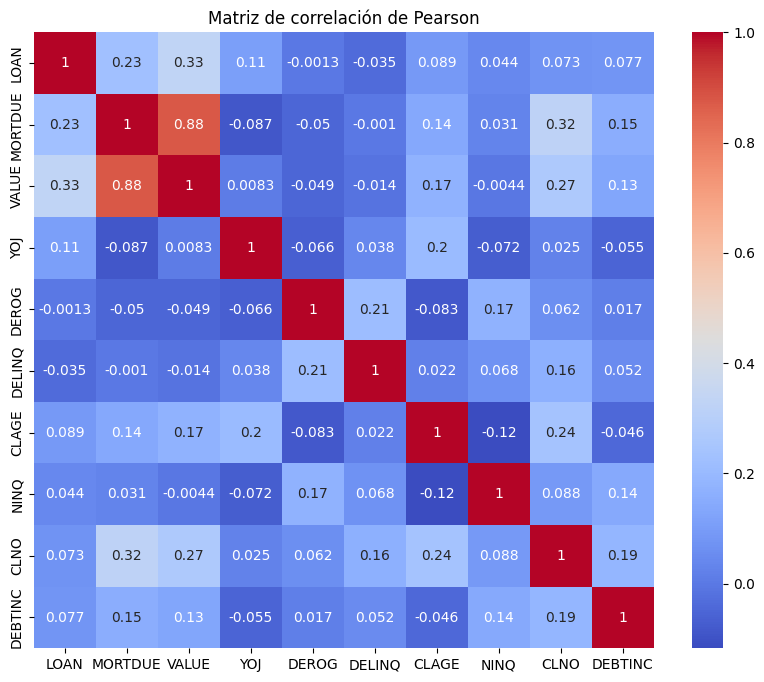

In [13]:
df_numeric = df.select_dtypes(include=['number'])
df_numeric.drop(columns='BAD', inplace=True)
corr = df_numeric.corr(method='pearson')

plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Matriz de correlación de Pearson')
plt.show()

Vemos que todas las variables están poco correlacionadas (entre -0.3 y 0.3). Esto es bueno ya que cada una aporta información distinta y por tanto todas van a ser útiles a priori para nuestro modelo.
Hay una excepción, y se trata de las variables MORTDUE y VALUE. Estas presentan una valor de 0.88, lo cual es una alta correlación. Más adelante veremos qué podemos hacer para mejorar esta situación.

# MODELADO SIN FEATURE ENIGNEERING

Vamos a realizar un primer entrenamiento de modelos "a lo bruto" usando nuestros datos tal cual vienen en el dataset con un procesamiento mínimo (simplemente quitaremos los valores faltantes de manera rápida). Como no vamos a tratar las variables categóricas, estas no pueden ser usadas como entradas del modelo, así que entrenaremos únicamente con las variables numéricas.
Imputaremos los missing de las variables numéricas usando la mediana, y los de las variables categóricas usando la moda.

In [14]:
df_raw = df.copy()

In [15]:
# Imputamos categóricas con la moda
for var in categ_var:
    df_raw[var] = df_raw[var].fillna(
        df_raw[var].mode()[0]
    )

In [16]:
# Imputamos numéricas con la media
for var in numeric_var:
    df_raw[var] = df_raw[var].fillna(df_raw[var].median())

Model: LogisticRegression
Accuracy: 0.7678, AUC-ROC: 0.8080, Recall: 0.6681, Precision: 0.4441, f2_score: 0.6069


C:\Users\Oscar\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


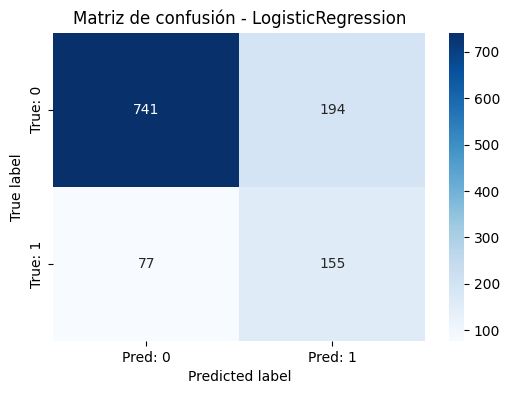

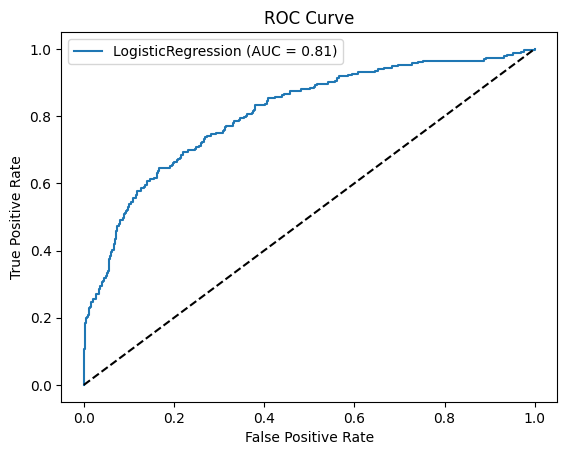

Model: DecisionTree
Accuracy: 0.8877, AUC-ROC: 0.8688, Recall: 0.6724, Precision: 0.7393, f2_score: 0.6848


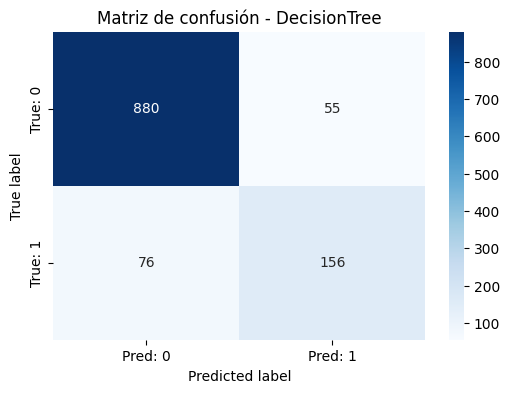

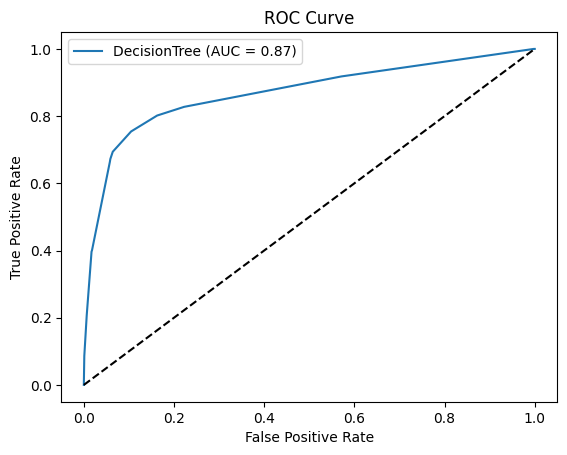

Model: RandomForest
Accuracy: 0.8963, AUC-ROC: 0.9445, Recall: 0.7457, Precision: 0.7362, f2_score: 0.7438


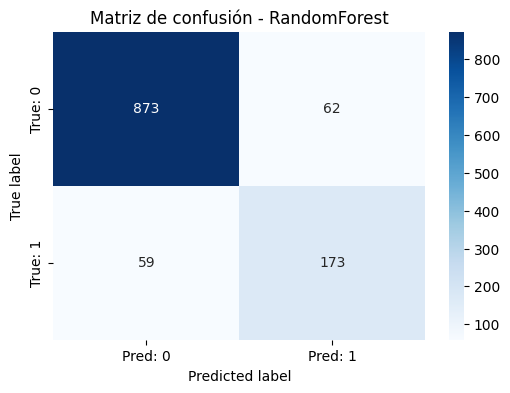

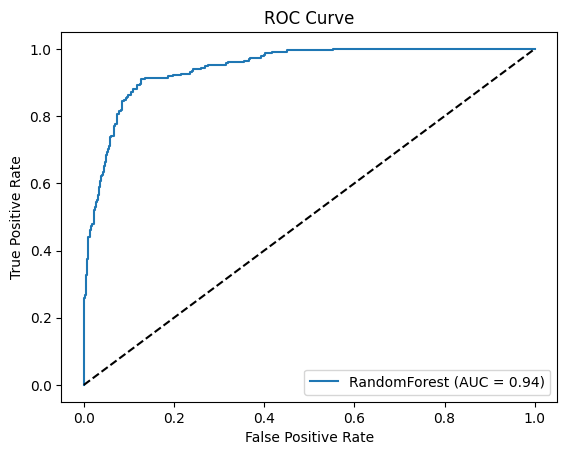

Model: XGBoost
Accuracy: 0.9066, AUC-ROC: 0.9585, Recall: 0.7069, Precision: 0.8000, f2_score: 0.7237


c:\Users\Oscar\.conda\envs\tfm\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:42:53] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


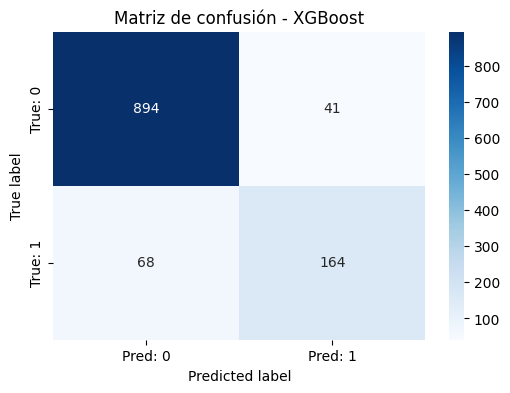

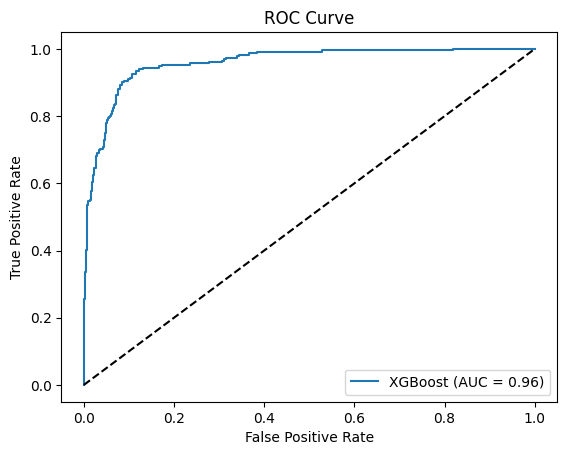

Model: SVM
Accuracy: 0.7087, AUC-ROC: 0.6031, Recall: 0.3190, Precision: 0.2891, f2_score: 0.3125


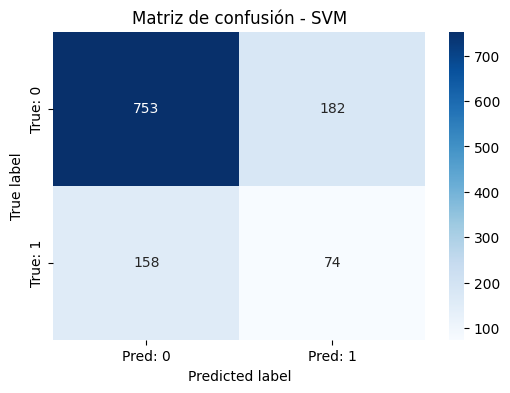

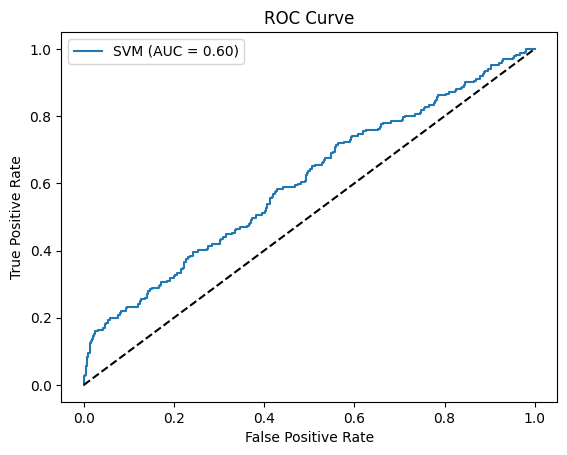

               Modelo  Accuracy    Recall       AUC  Precision  F2_score
0  LogisticRegression  0.767781  0.668103  0.807994   0.444126  0.606891
1        DecisionTree  0.887746  0.672414  0.868804   0.739336  0.684811
2        RandomForest  0.896315  0.745690  0.944500   0.736170  0.743766
3             XGBoost  0.906598  0.706897  0.958496   0.800000  0.723742
4                 SVM  0.708655  0.318966  0.603126   0.289062  0.312500


In [17]:
# MODELADO

# Separamos datos
X_raw = df_raw.drop(columns=categ_var)
X_raw = X_raw.drop(columns='BAD')
Y_raw = df_raw['BAD']

# Dividimos train y test
X_raw_train, X_raw_test, y_raw_train, y_raw_test = train_test_split(X_raw, Y_raw, test_size=0.2, random_state=0, stratify=Y_raw)

# Creamos el pipeline, añadiendo todos los modelos que queremos entrenar
pipeline = {
    'LogisticRegression': Pipeline([
        ('classifier', LogisticRegression(max_iter=1000, class_weight='balanced', random_state=0))
    ]),
    'DecisionTree': Pipeline([
        ('classifier', DecisionTreeClassifier(max_depth=5, random_state=0))
    ]),
    'RandomForest': Pipeline([
        ('classifier', RandomForestClassifier(n_estimators=200, max_depth=10, class_weight='balanced',  random_state=0))
    ]),
    'XGBoost': Pipeline([
        ('classifier', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=0))
    ]),
    'SVM': Pipeline([
        ('classifier', SVC(probability=True, class_weight='balanced', random_state=0))
    ])
}
# Entrenamos y evaluamos modelos
model_results_raw = []
y_probs = {}

for name, pipe in pipeline.items():
    pipe.fit(X_raw_train, y_raw_train)
    y_pred = pipe.predict(X_raw_test)
    y_prob = pipe.predict_proba(X_raw_test)[:,1]
    
    auc = roc_auc_score(y_raw_test, y_prob)
    acc = accuracy_score(y_raw_test, y_pred)
    recall = recall_score(y_raw_test, y_pred)
    precision = precision_score(y_raw_test, y_pred)
    f2 = fbeta_score(y_raw_test, y_pred, beta=2)

    # Guardamos métricas de cada modelo
    model_results_raw.append(
        {
            'Modelo' : name,
            'Accuracy' : acc,
            'Recall' : recall,
            'AUC' : auc,
            'Precision' : precision,
            'F2_score' : f2
        }
    )

    y_probs[name] = y_prob
    
    print(f'Model: {name}')
    print(
        f'Accuracy: {acc:.4f}, AUC-ROC: {auc:.4f}, Recall: {recall:.4f}, Precision: {precision:.4f}, f2_score: {f2:.4f}')
    
    # Matriz de confusión
    cm = confusion_matrix(y_raw_test, y_pred)
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Pred: 0','Pred: 1'], yticklabels=['True: 0','True: 1'])
    plt.title(f'Matriz de confusión - {name}')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    
    # Curva ROC
    fpr, tpr, _ = roc_curve(y_raw_test, y_prob)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc:.2f})')
    plt.plot([0,1],[0,1],'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()

results_raw_df = pd.DataFrame(model_results_raw)
print(results_raw_df)

Como en todo proyecto de Machine Learning, sabemos que hay una parte importante de estudio de los datos y procesamiento antes de entrenar los modelos, ya que se pueden obtener mejoras muy significativas si se hace bien. Por tanto, guardaremos estos resultados y los compararemos con los que obtengamos tras contar con los datos procesados.

# DATA PREPROCESSING

VARIABLES CATEGÓRICAS

Imputar missings:

Vemos que nuestras dos variables categóricas REASON y JOB, tienen un 2.86% y 2.98% de missing, respectivamente. Aunque no son muchos, aún podemos considerarlos una categoría nueva ya que pueden proporcionar información útil en el sector financiero. Por tanto, vamos a crear una categoría nueva para ellos:

In [18]:
for col in categ_var:
    df[col] = df[col].fillna('Missing')

Categorías poco representadas:

En la variable JOB encontramos una categoría demasiado minoritaria: Sales, con un 1.86% de frecuencia (consideramos que Self tiene suficientes apariciones al superar el 3%, con un 3.3%). Lo que haremos con ella será unirlo al bloque mayoritario de Other:

In [19]:
df['JOB'] = df['JOB'].replace('Sales', 'Other')

VARIABLES NUMÉRICAS

Atípicos:

Para reducir el impacto de esos valores extremos presentes en algunas variables, vamos a aplicar lo que se conoce como Winsorización. Winszorizar es el proceso de reemplazar los valores muy extremos por los valores del percentil X de esos mismos datos. En nuestro caso, winsorizaremos únicamente los valores superiores, y lo haremos al 99%, ya que tenemos variables con colas muy largas pero con poca cantidad de valores atípicos.

Vamos a decidir qué columnas queremos Winsorizar. Vamos a querer aquellas variables que estén muy sesgadas hacia la derecha (Skew > 1), y que sus valores extremos sean muy grandes respecto al de su percentil 99.

In [20]:
# Dataframe nuevo para guardar las estadísticas de cada columna
outliers = pd.DataFrame(columns=['Variable', 'Valor_Max', 'Percentil_99', 'Skew'])

# Calculamos las métricas para cada variable y lo guardamos en el df "outliers"
for var in numeric_var:
    max_value = df_numeric[var].max()
    percentile_99 = df_numeric[var].quantile(0.99)
    skew = df_numeric[var].skew()

    outliers = pd.concat([outliers, pd.DataFrame({
        'Variable': [var],
        'Valor_Max': [max_value],
        'Percentil_99': [percentile_99],
        'Skew': [skew]
    })], ignore_index=True)

wins_columns = outliers[
    (outliers['Skew'] > 1) & 
    (outliers['Valor_Max'] > 1.5 * outliers['Percentil_99'])
    ]['Variable'].tolist()

print(outliers.sort_values('Skew', ascending=False))
print('\n')
print('Columnas a Winsorizar:', wins_columns)

    

  Variable    Valor_Max   Percentil_99      Skew
4    DEROG         10.0       4.000000  5.320870
5   DELINQ         15.0       5.000000  4.023150
2    VALUE     855909.0  289996.580000  3.059737
9  DEBTINC   203.312149      49.371062  2.991577
7     NINQ         17.0       8.510000  2.621984
0     LOAN        89900   62137.000000  2.021307
1  MORTDUE     399550.0  232312.400000  1.816945
6    CLAGE  1168.233561     399.544930  1.343412
3      YOJ         41.0      30.000000  0.991646
8     CLNO         71.0      50.000000  0.775052


Columnas a Winsorizar: ['MORTDUE', 'VALUE', 'DEROG', 'DELINQ', 'CLAGE', 'NINQ', 'DEBTINC']


C:\Users\Oscar\AppData\Local\Temp\ipykernel_7476\1297560198.py:10: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  outliers = pd.concat([outliers, pd.DataFrame({


Según nuestro criterio de evaluación, deberíamos Winsorizar las columnas MORTDUE, VALUE, DEROG, DELINQ, CLAGE, NINQ y DEBTINC. Sin embargo, viendo que DEROG, DELINQ y NINQ son conteos pequeños, vamos a decidir no modificarlas para no perder información.

In [21]:
wins_columns = [col for col in wins_columns if col not in ['DEROG', 'DELINQ', 'NINQ']]
upper_percentile = 0.99
df_wins = df.copy()

for col in wins_columns:
    upper_value = df[col].quantile(upper_percentile)
    df_wins[col] = df[col].clip(upper=upper_value)

Solucionar colinealidad:

Anteriormente habíamos visto que existe una fuerte colinealidad entre las variables MORTDUE y VALUE. Para tratar de eliminarla, crearemos una variable nueva a partir de estas 2, y eliminaremos una de ellas. Concretamente, crearemos la variable MVR (Mortdue-Value-Ratio) a partir de dividir MORTDUE/VALUE, y después eliminaremos MORTDUE del dataset.

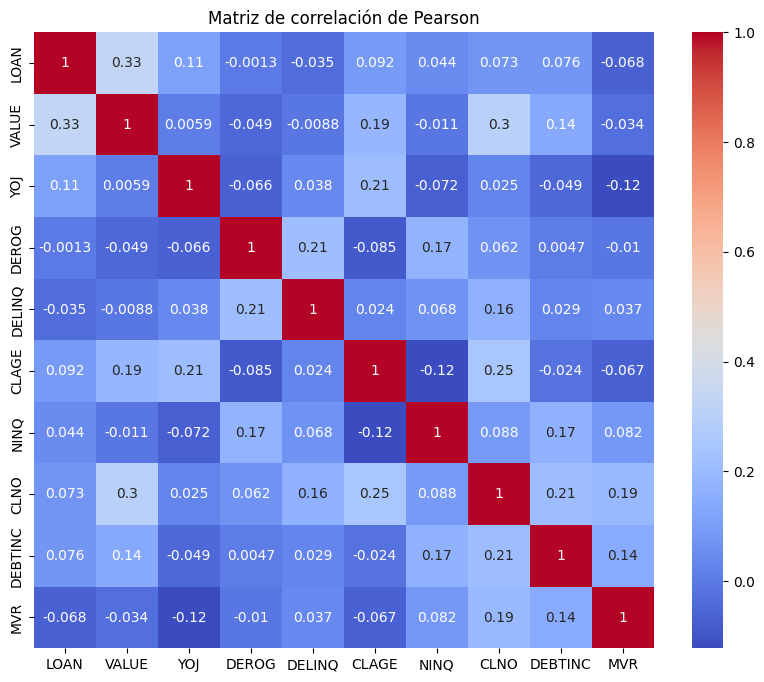

In [22]:
df_wins['MVR'] = df_wins['MORTDUE'] / df_wins['VALUE']
df_wins.drop(columns='MORTDUE', inplace=True)

df_numeric = df_wins.select_dtypes(include=['number'])
df_numeric.drop(columns='BAD', inplace=True)

corr = df_numeric.corr(method='pearson')

plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Matriz de correlación de Pearson')
plt.show()

Vamos a echar un vistazo a la distribución de la nueva variable MVR:

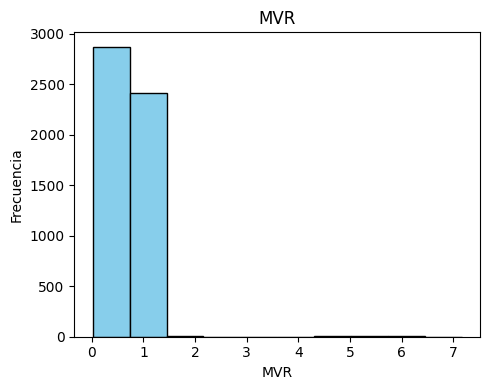

In [23]:
plt.figure(figsize=(5, 4))

plt.hist(df_wins['MVR'], bins=10, color='skyblue', edgecolor='black')
plt.title('MVR')
plt.xlabel('MVR')
plt.ylabel('Frecuencia')

plt.tight_layout()
plt.show()

In [24]:
# Dataframe nuevo para guardar las estadísticas de cada columna
outliers = pd.DataFrame(columns=['Variable', 'Valor_Max', 'Percentil_99', 'Skew'])

max_value = df_wins['MVR'].max()
percentile_99 = df_wins['MVR'].quantile(0.99)
skew = df_wins['MVR'].skew()

outliers = pd.concat([outliers, pd.DataFrame({
    'Variable': ['MVR'],
    'Valor_Max': [max_value],
    'Percentil_99': [percentile_99],
    'Skew': [skew]
})], ignore_index=True)

wins_columns = outliers[
    (outliers['Skew'] > 1) & 
    (outliers['Valor_Max'] > 1.5 * outliers['Percentil_99'])
    ]['Variable'].tolist()

print(outliers.sort_values('Skew', ascending=False))
print('\n')
print('Columnas a Winsorizar:', wins_columns)


  Variable  Valor_Max  Percentil_99       Skew
0      MVR     7.1625      0.995651  10.465151


Columnas a Winsorizar: ['MVR']


C:\Users\Oscar\AppData\Local\Temp\ipykernel_7476\1638394528.py:8: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  outliers = pd.concat([outliers, pd.DataFrame({


Vemos que la distribución de MVR está muy sesgada y presenta algunos valores muy extremos, por lo que podemos pensar en Winsorizarla. Aplicando el mismo criterio usado anteriormente, vemos que se confirma que debemos hacerlo.

In [25]:
upper_value = df_wins['MVR'].quantile(upper_percentile)
df_wins['MVR'] = df_wins['MVR'].clip(upper=upper_value)

Imputación missings:

Vamos a volver a mostrar la estadística de los datos missing tras las transformaciones realizadas a nuestro dataset:


In [26]:
missings = df_wins.isna().sum()
missings_rate = df_wins.isna().mean()*100

missing_df = pd.DataFrame({
    'Missing_Count': missings,
    'Missing_Percent': missings_rate
})
missing_df

,Missing_Count,Missing_Percent
BAD,0,0.000000
LOAN,0,0.000000
VALUE,95,1.628385
REASON,0,0.000000
JOB,0,0.000000
YOJ,408,6.993486
DEROG,582,9.976003
DELINQ,454,7.781968
CLAGE,182,3.119643
NINQ,384,6.582105


In [27]:
print(missing_df)

         Missing_Count  Missing_Percent
BAD                  0         0.000000
LOAN                 0         0.000000
VALUE               95         1.628385
REASON               0         0.000000
JOB                  0         0.000000
YOJ                408         6.993486
DEROG              582         9.976003
DELINQ             454         7.781968
CLAGE              182         3.119643
NINQ               384         6.582105
CLNO                96         1.645526
DEBTINC           1228        21.049023
MVR                521         8.930408


Viendo los porcentajes de missing para cada variable, decidimos lo siguiente:
- DEROG, DELINQ --> imputaremos los missing como 0, ya que es la categoría predominante con mucha diferencia
- VALUE, YOJ, CLAGE, NINQ, CLNO, MVR --> imputaremos usando la mediana. El porcentaje de datos missing es "aceptable", y por la distribución de los valores usaremos la mediana y no la media, ya que funciona mejor para datos sesgados.
- DEBTINC --> tiene un alto porcentaje de missing (21%), así que imputando con la media podríamos introducir demasiado error. Realizaremos una imputación más avanzada usando algún modelo predictivo.

In [28]:
df_full = df_wins.copy()
impute_zero = ['DEROG', 'DELINQ']
impute_median = ['VALUE', 'YOJ', 'CLAGE', 'NINQ', 'CLNO', 'MVR']

for col in impute_zero:
    df_full[col] = df_full[col].fillna(0)

for col in impute_median:
    df_full[col] = df_full[col].fillna(df_full[col].median())


In [29]:
# Imputación de DEBTINC por modelo
vars = ['LOAN', 'VALUE', 'YOJ', 'CLAGE', 'NINQ', 'CLNO', 'MVR','DEROG', 'DELINQ', 'JOB', 'REASON']

train = df_full[df_full['DEBTINC'].notna()].drop(columns='BAD')
predict = df_full[df_full['DEBTINC'].isna()].drop(columns='BAD')

train_dummies = pd.get_dummies(train[vars], drop_first=True)
predict_dummies = pd.get_dummies(predict[vars], drop_first=True)

model = RandomForestRegressor(random_state=0)
# Entrenamos con el dataset que no contiene la variable objetivo DEBTINC y que contiene las variables categóricas dummificadas.
model.fit(train_dummies, train['DEBTINC'])

predicted_debtinc = model.predict(predict_dummies)

df_full.loc[df_full['DEBTINC'].isna(), 'DEBTINC'] = predicted_debtinc

In [30]:
df_full.isna().sum()

BAD        0
LOAN       0
VALUE      0
REASON     0
JOB        0
YOJ        0
DEROG      0
DELINQ     0
CLAGE      0
NINQ       0
CLNO       0
DEBTINC    0
MVR        0
dtype: int64

Ahora tenemos un dataset limpio, sin valores faltantes, sin categorías poco representadas, sin colinealidad y sin valores atípicos. Vamos a representar de nuevo nuestras variables numéricas para ver si su distribución ha cambiado o no, y decidir si debemos aplicar algun tipo de transformación adicional.

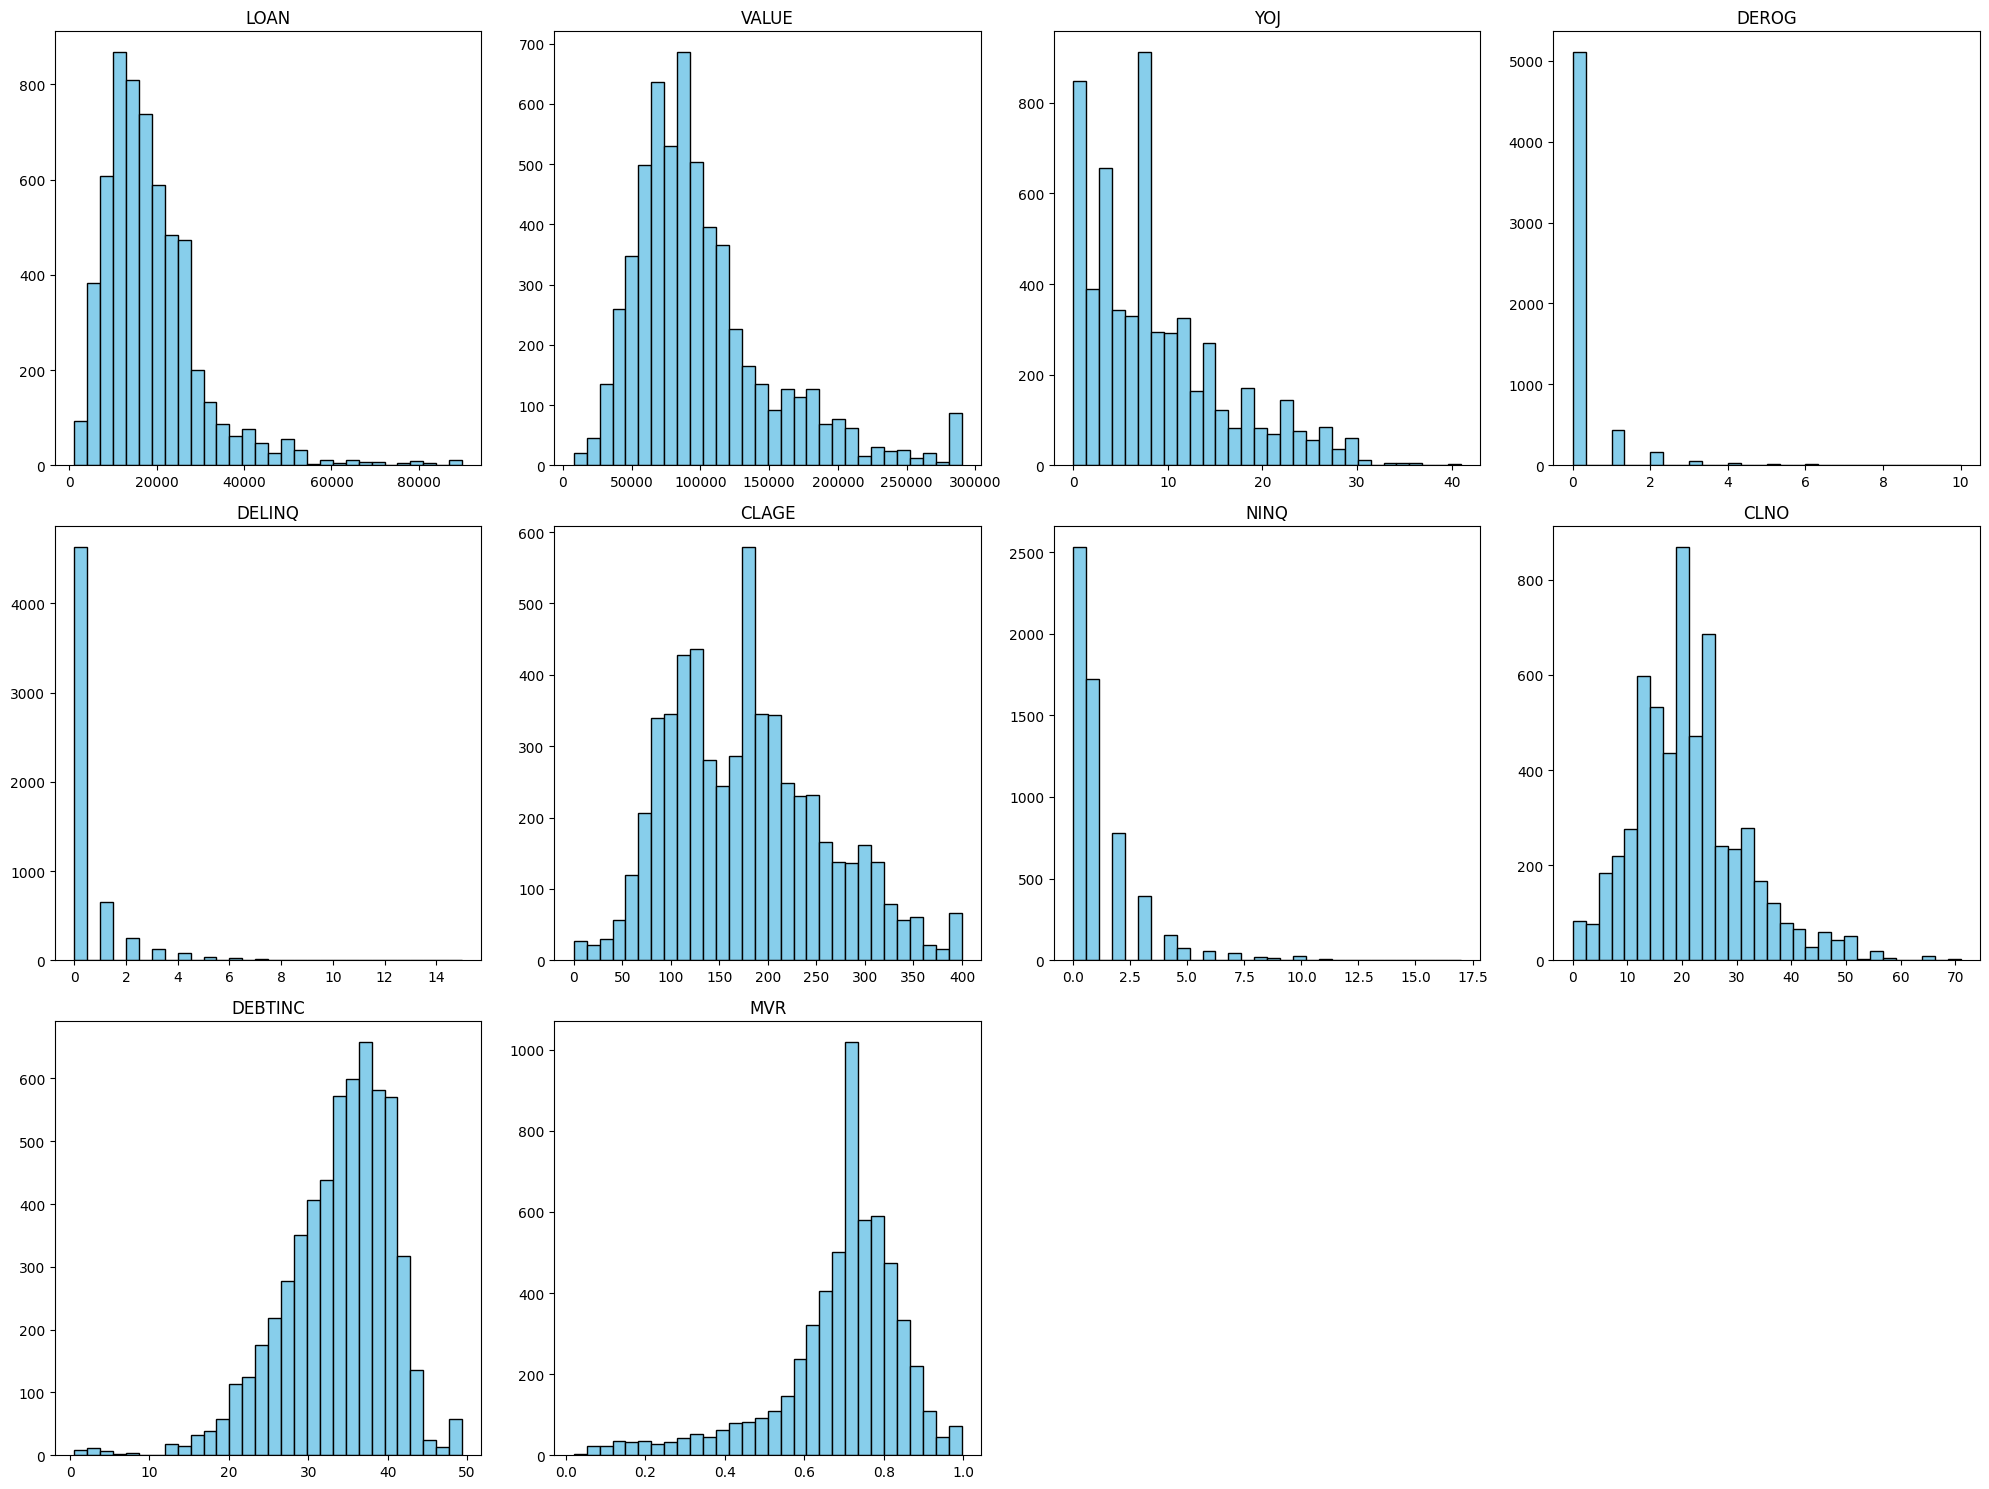

In [31]:
numeric_var = df_full.select_dtypes(include=['number']).columns.tolist()
numeric_var.remove('BAD')

# Número de columnas numéricas
n = len(numeric_var)

n_cols = 4
n_rows = (n + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5*n_rows))
axes = axes.flatten()

# Iteramos sobre cada columna numérica
for i, col in enumerate(numeric_var):
    axes[i].hist(df_full[col].dropna(), bins=30, color="skyblue", edgecolor="black")
    axes[i].set_title(col)

# Para ocultar los gráficos vacíos que "sobran"
for j in range(i+1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

Al Winsorizar ya hemos eliminado el sesgo de algunas variables, pero hay otras que siguen estando bastante sesgadas a la derecha. En esos casos (LOAN, VALUE, YOJ), vamos a aplicar una transformación logarítmica que las aproxime más a una distribución normal. Las variables DEROG, DELINQ y NINQ no se van a transformar a pesar de su distribución dado que son variables de conteo pequeño discretas, así que podríamos perder interpretabilidad al aplicarles un logaritmo.

In [32]:
log_var = ['LOAN', 'VALUE', 'YOJ']
for var in log_var:
    df_full[var] = np.log1p(df_full[var])
    df_full = df_full.rename(columns={var : f'{var}_log'})


Finalizada la fase de procesamiento de los datos, echamos un vistazo al estado actual de nuestras variables numéricas:

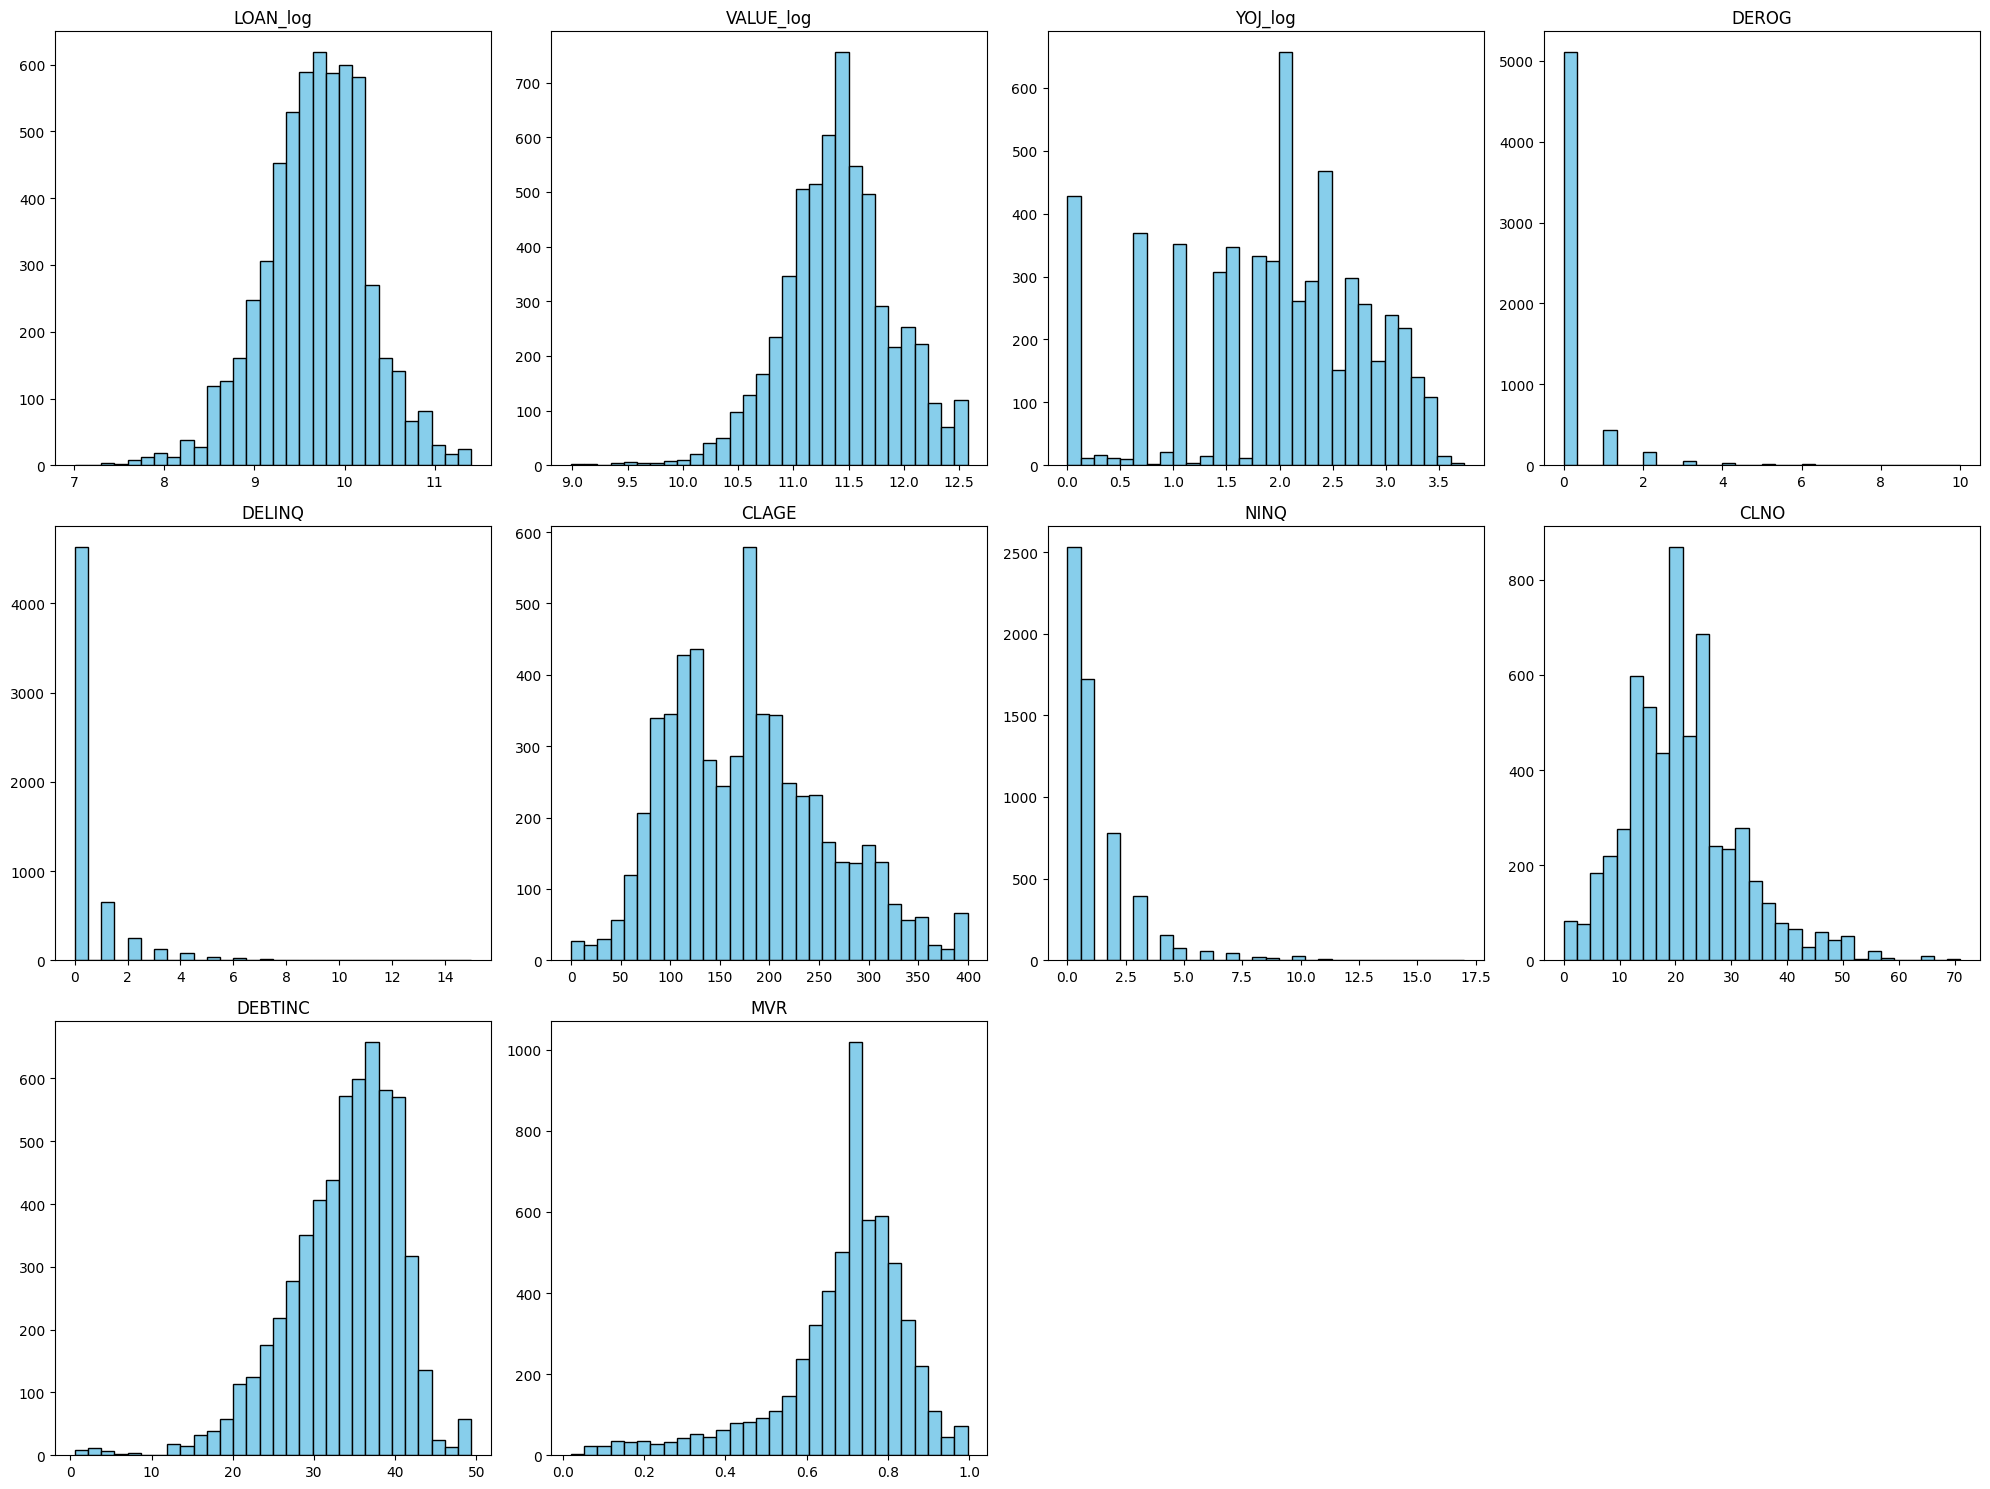

In [33]:
numeric_var = df_full.select_dtypes(include=['number']).columns.tolist()
numeric_var.remove('BAD')

n_cols = 4
n_rows = (n + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5*n_rows))
axes = axes.flatten()

# Iteramos sobre cada columna numérica
for i, col in enumerate(numeric_var):
    axes[i].hist(df_full[col].dropna(), bins=30, color="skyblue", edgecolor="black")
    axes[i].set_title(col)

# Para ocultar los gráficos vacíos que "sobran"
for j in range(i+1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

# ANÁLISIS EDA FINAL

Vamos a ver las correlaciones entre nuestras variables explicativas (numéricas y categóricas) y la variable objetivo BAD.

Correlación de variables numéricas con BAD:
DELINQ       0.351553
DEROG        0.273656
NINQ         0.172164
DEBTINC      0.114602
MVR          0.003914
CLNO        -0.004441
YOJ_log     -0.051212
VALUE_log   -0.087691
LOAN_log    -0.132444
CLAGE       -0.180319
dtype: float64


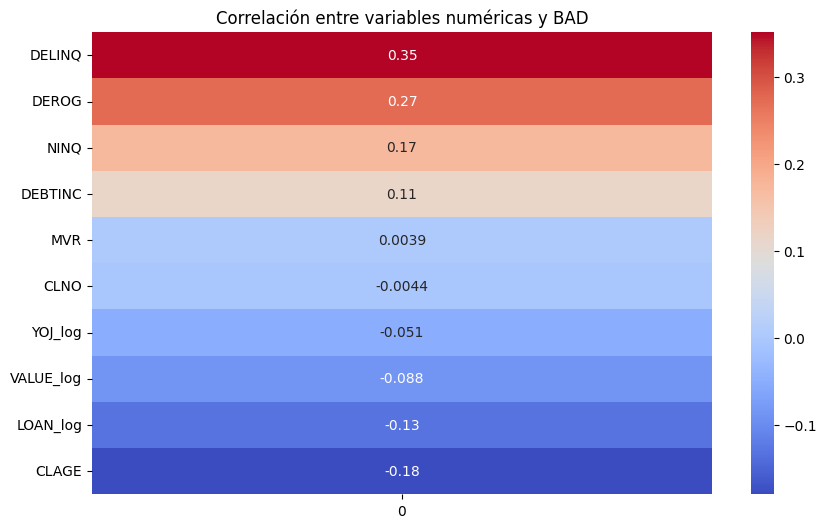

In [34]:
corr_num = df_full[numeric_var].corrwith(df_full['BAD']).sort_values(ascending=False)
print('Correlación de variables numéricas con BAD:')
print(corr_num)

# Gráfico tipo heatmap
plt.figure(figsize=(10,6))
sns.heatmap(corr_num.to_frame(), annot=True, cmap='coolwarm')
plt.title('Correlación entre variables numéricas y BAD')
plt.show()

Vemos que algunas variables tienen correlación positiva con BAD, como DELINQ, relación que se entiende ya que cuantos más créditos haya impagado un cliente, mayor probabilidad hay de que vuelva a fallar.

Otras variables tienen correlaciones negativas con BAD. Por ejemplo CLAGE, ya que podríamos considerar que cuánto más antiguo es el crédito de un cliente, más estable y fiable es, disminuyendo la probabilidad de BAD=1.

Otras variables casi no tienen mucha relación con BAD por sí solas, pero seguramente sí ayudarán al combinarlas en un modelo.


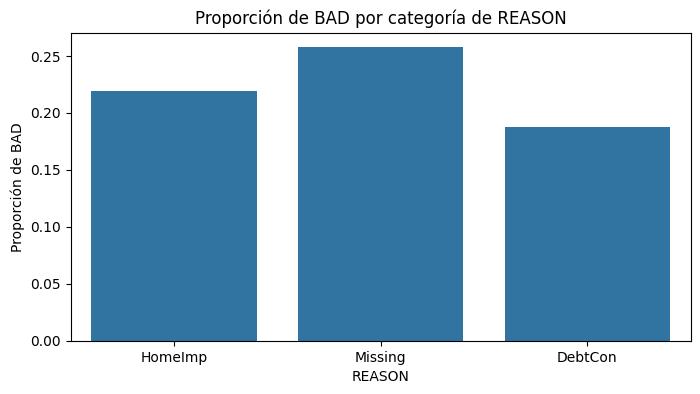

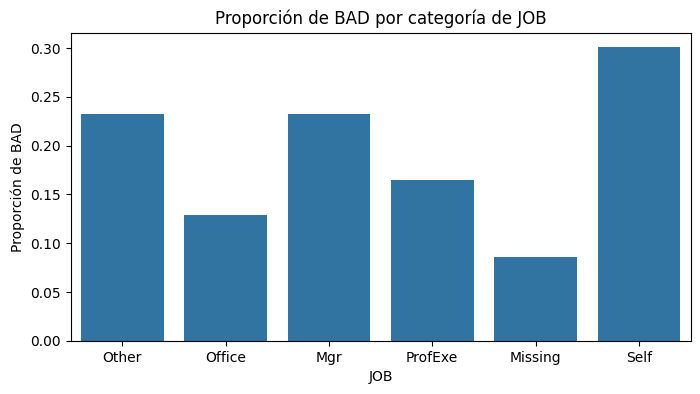

In [35]:
for col in categ_var:
    plt.figure(figsize=(8,4))
    sns.barplot(x=col, y='BAD', data=df_full, errorbar=None)
    plt.title(f'Proporción de BAD por categoría de {col}')
    plt.ylabel('Proporción de BAD')
    plt.show()

En REASON, la categoría Missing presenta una proporción de BAD más alta de lo normal (recordemos, un 19,9%). Parece que los clientes que no informan del motivo del préstamo tienen más riesgo. Lo mismo para HomeImp. Esta variable sí parece dar información útil.

En cuanto a JOB, la categoría Self (los autónomos) tiene mucha más probabilidad de impago, probablemente debido a ingresos inestables. Otras categorías se sitúan por debajo de la media, así que la variable parece dar también muy buena información.


# MODELADO

In [36]:
# Separamos variables explicativas de variable objetivo
X = df_full.drop('BAD', axis=1)
Y = df_full['BAD']

In [37]:
# Dividimos train y test
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0, stratify=Y)

In [38]:
# Definimos el transformador para las variables numéricas y categóricas
preprocessor = ColumnTransformer(
    transformers=[
        ('numeric', StandardScaler(), numeric_var),
        ('categoric', OneHotEncoder(drop='first'), categ_var)
    ]
)

In [39]:
# Creamos el pipeline, añadiendo todos los modelos que queremos entrenar
k = 17
pipeline = {
    'LogisticRegression': Pipeline([
        ('preprocessor', preprocessor),
        ('var_selector', SelectKBest(k=k)),
        ('classifier', LogisticRegression(max_iter=1000, class_weight='balanced', random_state=0))
    ]),
    'DecisionTree': Pipeline([
        ('preprocessor', preprocessor),
        ('var_selector', SelectKBest(k=k)),
        ('classifier', DecisionTreeClassifier(random_state=0))
    ]),
    'RandomForest': Pipeline([
        ('preprocessor', preprocessor),
        ('var_selector', SelectKBest(k=k)),
        ('classifier', RandomForestClassifier(class_weight='balanced',  random_state=0))
    ]),
    'XGBoost': Pipeline([
        ('preprocessor', preprocessor),
        ('var_selector', SelectKBest(k=k)),
        ('classifier', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=0))
    ]),
    'SVM': Pipeline([
        ('preprocessor', preprocessor),
        ('var_selector', SelectKBest(k=k)),
        ('classifier', SVC(probability=True, class_weight='balanced', random_state=0))
    ])
}

In [40]:
# Rejilla de hiperparámetros para GridSearchCV
param_grid = {
    'DecisionTree': {
        'classifier__max_depth': [3,5,7,10],
        'classifier__min_samples_split': [2,5,10]
    },
    'RandomForest': {
        'classifier__n_estimators': [100,200],
        'classifier__max_depth': [5,10,15],
        'classifier__min_samples_split': [2,5,10]
    },
    'XGBoost': {
        'classifier__n_estimators': [100,200],
        'classifier__max_depth': [3,5,7],
        'classifier__learning_rate': [0.01,0.1,0.2]
    },
    'SVM': {
        'classifier__C': [0.1,1,10],
        'classifier__kernel': ['rbf','linear']
    }
}

Model: LogisticRegression
Threshold óptimo según F2-score (LogisticRegression): 0.37
Accuracy: 0.6701, AUC-ROC: 0.8155, Recall: 0.8190, Precision: 0.3565, f2_score: 0.6502


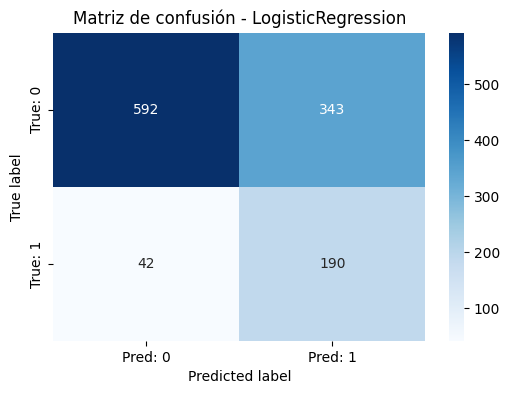

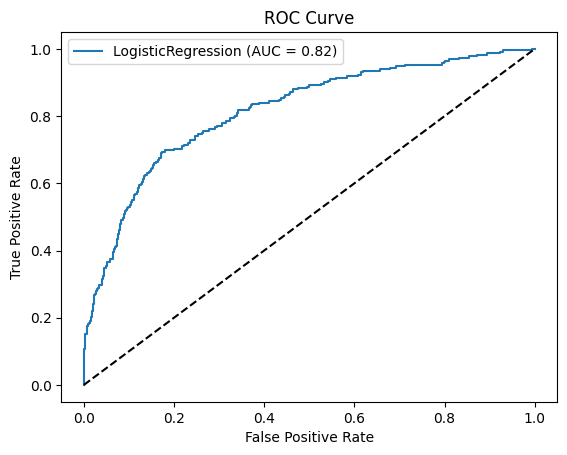

Mejores hiperparámetros para DecisionTree: {'classifier__max_depth': 10, 'classifier__min_samples_split': 2}
Model: DecisionTree
Threshold óptimo según F2-score (DecisionTree): 0.14
Accuracy: 0.8226, AUC-ROC: 0.8115, Recall: 0.6897, Precision: 0.5424, f2_score: 0.6541


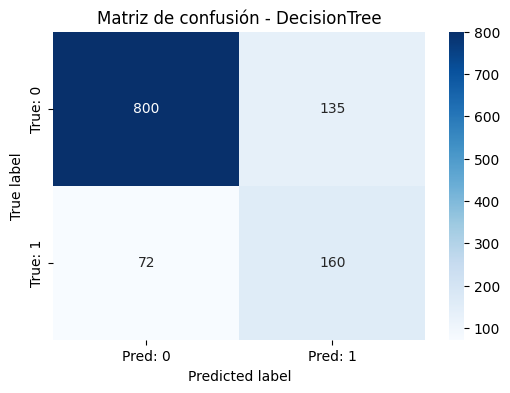

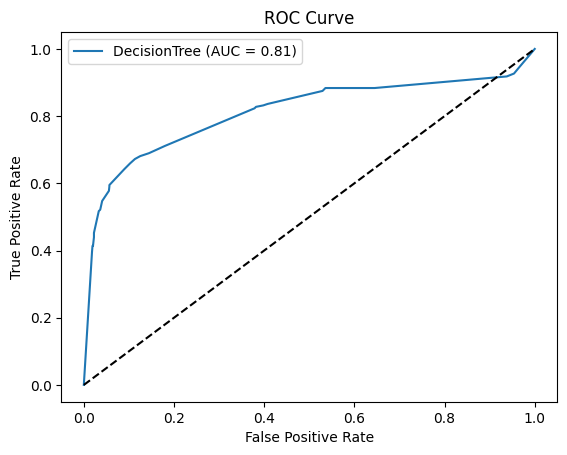

Mejores hiperparámetros para RandomForest: {'classifier__max_depth': 15, 'classifier__min_samples_split': 10, 'classifier__n_estimators': 200}
Model: RandomForest
Threshold óptimo según F2-score (RandomForest): 0.34
Accuracy: 0.9195, AUC-ROC: 0.9685, Recall: 0.9181, Precision: 0.7396, f2_score: 0.8758


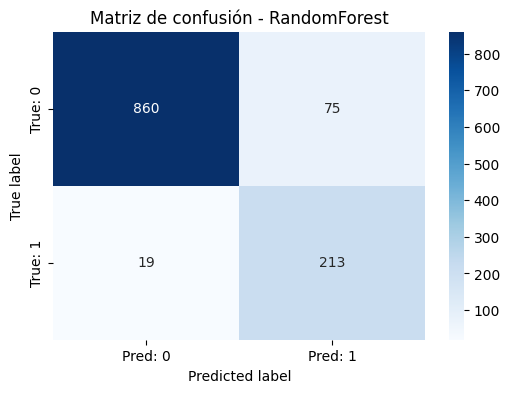

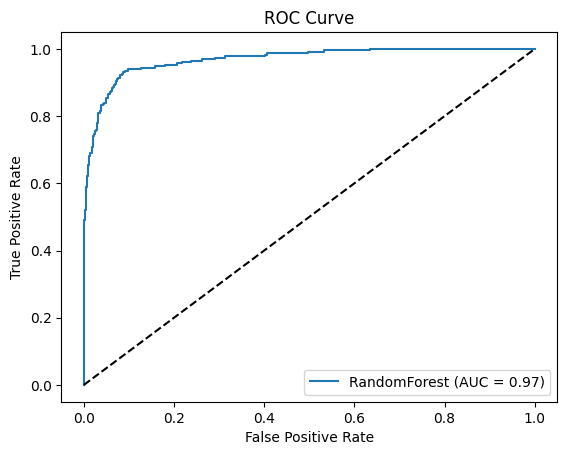

c:\Users\Oscar\.conda\envs\tfm\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:43:10] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Mejores hiperparámetros para XGBoost: {'classifier__learning_rate': 0.2, 'classifier__max_depth': 7, 'classifier__n_estimators': 200}
Model: XGBoost
Threshold óptimo según F2-score (XGBoost): 0.07
Accuracy: 0.9332, AUC-ROC: 0.9703, Recall: 0.8750, Precision: 0.8056, f2_score: 0.8602


c:\Users\Oscar\.conda\envs\tfm\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:43:10] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


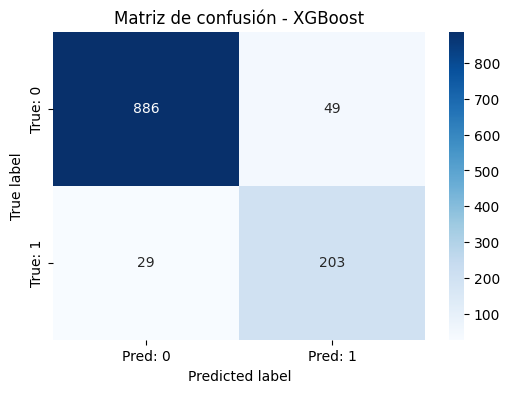

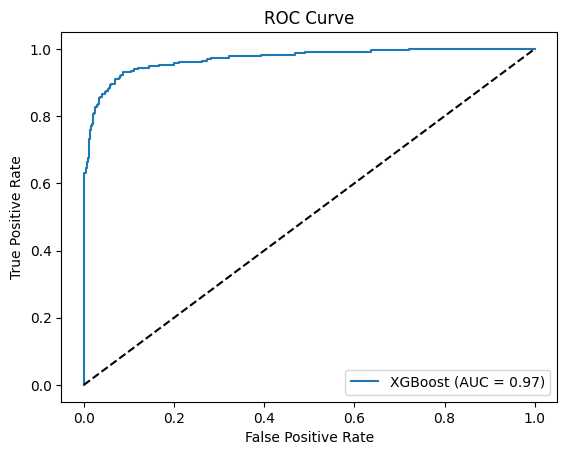

Mejores hiperparámetros para SVM: {'classifier__C': 10, 'classifier__kernel': 'rbf'}
Model: SVM
Threshold óptimo según F2-score (SVM): 0.18
Accuracy: 0.9109, AUC-ROC: 0.9457, Recall: 0.8319, Precision: 0.7481, f2_score: 0.8137


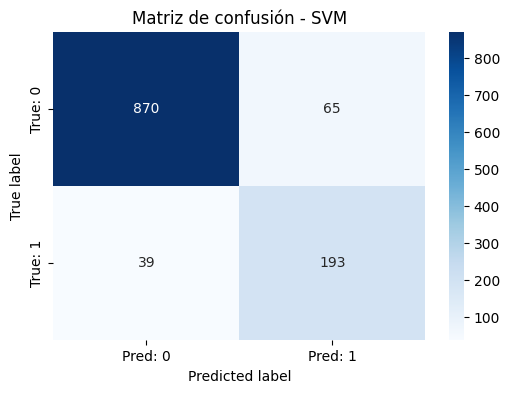

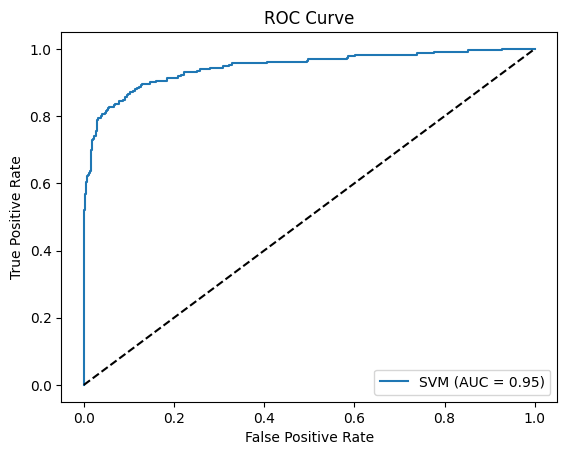

               Modelo  Accuracy    Recall       AUC  Precision  F2_score  \
0  LogisticRegression  0.670094  0.818966  0.815531   0.356473  0.650240   
1        DecisionTree  0.822622  0.689655  0.811516   0.542373  0.654129   
2        RandomForest  0.919452  0.918103  0.968463   0.739583  0.875822   
3             XGBoost  0.933162  0.875000  0.970256   0.805556  0.860169   
4                 SVM  0.910883  0.831897  0.945717   0.748062  0.813659   

   Threshold  
0       0.37  
1       0.14  
2       0.34  
3       0.07  
4       0.18  

--- Selección de variables ---
Total de features tras preprocesado: 17
Número de features seleccionadas: 17
Variables seleccionadas:
['LOAN_log' 'VALUE_log' 'YOJ_log' 'DEROG' 'DELINQ' 'CLAGE' 'NINQ' 'CLNO'
 'DEBTINC' 'MVR' 'REASON_HomeImp' 'REASON_Missing' 'JOB_Missing'
 'JOB_Office' 'JOB_Other' 'JOB_ProfExe' 'JOB_Self']
----------------------------------------



In [41]:
# Entrenar todos los modelos y obtener sus métricas
model_results = []
y_probs = {}

f2_scorer = make_scorer(fbeta_score, beta=2)

# CV estratificado
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

for name, pipe in pipeline.items():
    # GridSearch para los modelos especificados
    if name in param_grid:
        grid = GridSearchCV(pipe, param_grid[name], scoring=f2_scorer, cv=cv, n_jobs=-1)
        grid.fit(X_train, y_train)
        best_model = grid.best_estimator_
        print(f'Mejores hiperparámetros para {name}: {grid.best_params_}')
    else:
        best_model = pipe
        best_model.fit(X_train, y_train)
    
    y_prob_cv = cross_val_predict(best_model, X_train, y_train, cv=cv, method='predict_proba', n_jobs=-1)[:,1]

    # Buscamos el threshold que maximiza el F2-score
    thresholds = np.arange(0.0, 1.01, 0.01)
    f2_scores = [fbeta_score(y_train, y_prob_cv > t, beta=2) for t in thresholds]
    best_threshold = thresholds[np.argmax(f2_scores)]

    # Entrenamos y predecimos finalmente con el threshold encontrado
    best_model.fit(X_train, y_train)
    y_prob = best_model.predict_proba(X_test)[:,1]
    y_pred = (y_prob >= best_threshold).astype(int)
    
    y_probs[name] = y_prob # Guardamos y_prob de cada modelo

    auc = roc_auc_score(y_test, y_prob)
    acc = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    f2 = fbeta_score(y_test, y_pred, beta=2)
    
    # Guardamos métricas de cada modelo
    model_results.append(
        {
            'Modelo' : name,
            'Accuracy' : acc,
            'Recall' : recall,
            'AUC' : auc,
            'Precision' : precision,
            'F2_score' : f2,
            'Threshold' : best_threshold
        }
    )
    
    print(f'Model: {name}')
    print(f'Threshold óptimo según F2-score ({name}): {best_threshold:.2f}')
    print(
        f'Accuracy: {acc:.4f}, AUC-ROC: {auc:.4f}, Recall: {recall:.4f}, Precision: {precision:.4f}, f2_score: {f2:.4f}')
    
    # Matriz de confusión
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Pred: 0','Pred: 1'], yticklabels=['True: 0','True: 1'])
    plt.title(f'Matriz de confusión - {name}')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    
    # Curva ROC
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc:.2f})')
    plt.plot([0,1],[0,1],'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()

results_df = pd.DataFrame(model_results)
print(results_df)
# Info de selección de variables
selector = best_model.named_steps['var_selector']
mask = selector.get_support()

# Nombres de variables tras preprocessor
ohe = best_model.named_steps['preprocessor'].named_transformers_['categoric']
ohe_features = ohe.get_feature_names_out(categ_var)
all_features = numeric_var + list(ohe_features)

selected_features = np.array(all_features)[mask]

print(f'\n--- Selección de variables ---')
print(f'Total de features tras preprocesado: {len(all_features)}')
print(f'Número de features seleccionadas: {mask.sum()}')
print('Variables seleccionadas:')
print(selected_features)
print('----------------------------------------\n')

Viendo estos resultados, rápidamente identificamos dos modelos destacados debido a prácticamente todas sus métricas, en especial el F2-score: el RandomForest y el XGBoost.

Cualquiera de estos dos se podría considerar un muy buen modelo ya que tienen F2-score muy altos, AUC muy buenas y recall bastante altos a la vez que se mantiene una precisión buena. Sin embargo, si tenemos que escoger un modelo final, nos decantamos por el RandomForest. El punto clave que lo diferencia del XGBoost es el recall notablemente mayor, de 0.9181 frente a 0.875. Es cierto que esto sucede a costa de perder precisión, pero consideramos que la diferencia no es tanta y aceptamos la precisión de 0.7396 como válida.


In [42]:
rf_model = RandomForestClassifier(
    class_weight='balanced',
    random_state=0,
    max_depth=15,
    min_samples_split=10,
    n_estimators=200
)

joblib.dump(rf_model, 'rf_model.pkl')

['rf_model.pkl']

Finalizaremos este apartado haciendo una comparación con los resultados obtenidos de los modelos en este modelado y en el anterior sin Feature Engineering.

En general, todos los modelos mejoran su desempeño. Algunos más y otros menos, específicamente los modelos no lineales (RandomForest +0.13, XGBoost +0.14, SVM +0.50) son los que más mejoran debido a que aprovechan mejor la preparación de los datos. En cambio, los lineales como la regresión logística (+0.05) no experimentan tanta mejora ya que sigue habiendo presentes no linealidades entre las variables explicativas y objetivo. 

Donde sí vemos gran mejora es en los recall conseguidos, gracias también a la elección del threshold óptimo. Además, en los modelos no lineales se ha hecho sin disminuir la precisión, en algunos casos incluso aumentándola. Como conclusión, podemos decir que el preprocesado de datos ha sido clave en la mejora de nuestros modelos.


# TARJETA DE PUNTUACIÓN

Ahora vamos a buscar construir un sistema de puntuación o scoring para traducir estas probabilidades de que un cliente cometa impago a un dato que sea más operativo a nivel de negocio. Estableceremos un sistema que otorgue altas puntuaciones a clientes potencialmente buenos, y bajas a aquellos para los que se estime que cometerán impago.

Hasta ahora hemos probado varios tipos de algoritmo y hemos visto que el que ofrece mejores resultados predictivos es el Random Forest, seguido del XGBoost. Sin embargo, en el ámbito del riesgo de crédito generalmente se usan siempre modelos de regresión logística. Esto es principalmente debido a su interpretabilidad y a la facilidad para convertir los resultados en una puntuación numérica, que es lo que buscamos obtener.

Por tanto, vamos a construir un nuevo modelo de regresión logística siguiendo un método que permite la construcción del sistema de puntuación:
- Discretizamos las variables buscando los tramos óptimos
- Transformarmos de nuevo las variables a numéricas calculando su WoE
- Seleccionaremos las variables más predictivas para entrenar el modelo sólo con ellas (IV > 0.02)
- Entrenar y evaluar el modelo de regresión logística

Para tramificar las variables de manera sencilla y óptima, usaremos la librería Optbinning.

In [43]:
# Tramificación con BinningProcess

binning_process = BinningProcess(
    variable_names= numeric_var + categ_var,
    categorical_variables= categ_var,
    # Seleccionamos solo las variables con IV >= 0.02
    selection_criteria={
        'iv' : {'min' : 0.02}
    }
)

binning_process.fit(X_train, y_train)

BinningProcess(categorical_variables=['REASON', 'JOB'],
               selection_criteria={'iv': {'min': 0.02}},
               variable_names=['LOAN_log', 'VALUE_log', 'YOJ_log', 'DEROG',
                               'DELINQ', 'CLAGE', 'NINQ', 'CLNO', 'DEBTINC',
                               'MVR', 'REASON', 'JOB'])

In [44]:
# Transformación a WoE
X_train_woe = binning_process.transform(X_train, metric='woe')
X_test_woe = binning_process.transform(X_test, metric='woe')

Threshold óptimo según F2-score: 0.14


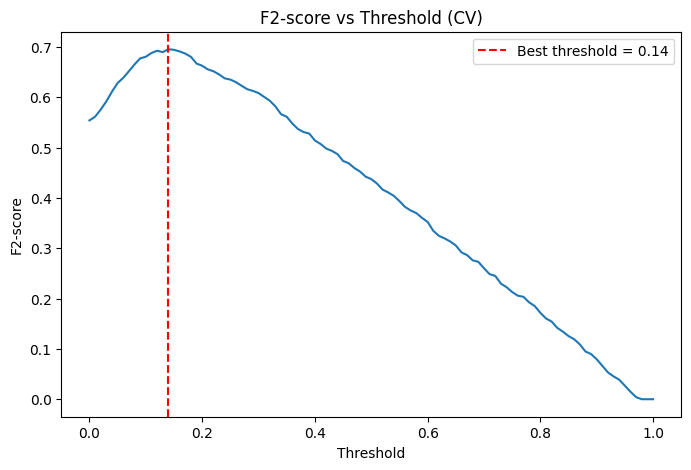

Accuracy: 0.7044, AUC-ROC: 0.8370, Recall: 0.8233, Precision: 0.3859, f2_score: 0.6711


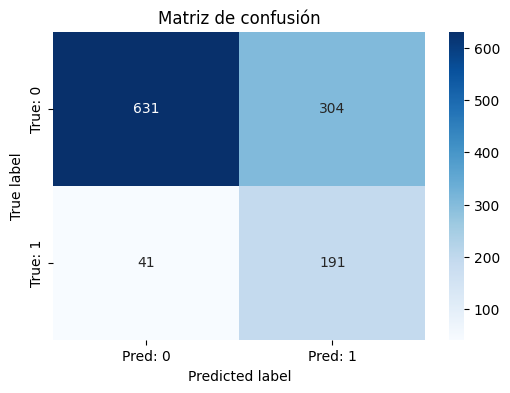

In [45]:
# Entrenamos modelo

model = LogisticRegression(max_iter=1000, penalty=None, random_state=0)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

y_prob_cv = cross_val_predict(model, X_train_woe, y_train, cv=cv, method='predict_proba', n_jobs=-1)[:,1]

# Buscamos el threshold que maximiza el F2-score
thresholds = np.arange(0.0, 1.01, 0.01)
f2_scores = [fbeta_score(y_train, y_prob_cv > t, beta=2) for t in thresholds]
best_threshold = thresholds[np.argmax(f2_scores)]
print(f'Threshold óptimo según F2-score: {best_threshold:.2f}')

# Graficamos F2 según el threshold
plt.figure(figsize=(8,5))
plt.plot(thresholds, f2_scores)
plt.axvline(best_threshold, color='r', linestyle='--', label=f'Best threshold = {best_threshold:.2f}')
plt.title('F2-score vs Threshold (CV)')
plt.xlabel('Threshold')
plt.ylabel('F2-score')
plt.legend()
plt.show()

# Entrenamos el modelo final con el threshold óptimo y evaluamos
model.fit(X_train_woe,y_train)
y_prob = model.predict_proba(X_test_woe)[:,1]
y_pred = (y_prob >= best_threshold).astype(int)

# Calculamos métricas de evaluación
auc = roc_auc_score(y_test, y_prob)
acc = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
f2 = fbeta_score(y_test, y_pred, beta=2)

print(
        f'Accuracy: {acc:.4f}, AUC-ROC: {auc:.4f}, Recall: {recall:.4f}, Precision: {precision:.4f}, f2_score: {f2:.4f}')

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Pred: 0','Pred: 1'], yticklabels=['True: 0','True: 1'])
plt.title(f'Matriz de confusión')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()



Ahora ya tenemos nuestro modelo de regresión logística que nos va a permitir construir las puntuaciones numéricas. Vemos que su capacidad predictiva, como era esperado, es bastante inferior a los mejores modelos encontrados anteriormente, pero por lo menos hemos conseguido un recall aceptable, que es nuestra prioridad ya que sobre todo queremos minimizar la cantidad de clientes malos que dejamos pasar.

Lo siguiente será construir la tarjeta de puntuación: 

In [46]:
scorecard = Scorecard(
    binning_process=binning_process,
    estimator=model,
    scaling_method='pdo_odds',
    scaling_method_params={
        'pdo': 20,
        'scorecard_points' : 600,
        'odds' : 50
    }
)

scorecard.fit(X_train, y_train)

Scorecard(binning_process=BinningProcess(categorical_variables=['REASON',
                                                                'JOB'],
                                         selection_criteria={'iv': {'min': 0.02}},
                                         variable_names=['LOAN_log',
                                                         'VALUE_log', 'YOJ_log',
                                                         'DEROG', 'DELINQ',
                                                         'CLAGE', 'NINQ',
                                                         'CLNO', 'DEBTINC',
                                                         'MVR', 'REASON',
                                                         'JOB']),
          estimator=LogisticRegression(max_iter=1000, penalty=None,
                                       random_state=0),
          scaling_method='pdo_odds',
          scaling_method_params={'odds': 50, 'pdo': 20,
                                 'scorecard_points': 600})

In [47]:
scorecard_table = scorecard.table()
scorecard_table.head()

# Guardamos la scorecard como archivo para poder ser usada luego de manera fácil
scorecard_table.to_excel('scorecard_table.xlsx', index=False)

In [48]:
scores = scorecard.score(X_test)
scores_df = pd.DataFrame({
    'CustomerID': X_test.index,
    'Score': scores
})
scores_df.head()

,CustomerID,Score
0,4180,540.669191
1,3210,581.738621
2,3436,486.745813
3,392,511.090848
4,3214,572.251529


Finalmente ya tenemos un sistema de puntuación que nos permite otorgar una puntuación numérica a cada cliente en función de su calidad crediticia. También disponemos de la tarjeta que nos indica cuántos puntos otorga cada posible valor de cada variable, de manera que podemos ver de manera muy fácil qué variables y valores tienen más importancia de cara a predecir el impago de un cliente.

Vamos a ir un poco más allá y vamos a mostrar la distribución de malos pagadores según su scoring para determinar si nuestro sistema de puntuación funciona de manera correcta.

In [49]:
df_contingency = pd.DataFrame({
    'Score': scores,
    'Target': y_test
})

# Crear bins (score dividida en deciles)
df_contingency['Score_bin'] = pd.qcut(df_contingency['Score'], 10, duplicates='drop')

# Tabla de contingencia por bin
df_contingency = df_contingency.groupby('Score_bin').agg(
    Count=('Target', 'count'),
    Bad=('Target', 'sum')
).reset_index()

# Calcular ratio de BAD por bin
df_contingency['BAD_ratio'] = df_contingency['Bad'] / df_contingency['Count']

# Ordenar de mayor a menor score
df_contingency = df_contingency.sort_values(by='Score_bin', ascending=False)

print(df_contingency)

                       Score_bin  Count  Bad  BAD_ratio
9             (592.103, 671.152]    117    0   0.000000
8             (578.509, 592.103]    117    2   0.017094
7             (569.291, 578.509]    114    4   0.035088
6             (560.131, 569.291]    119   10   0.084034
5             (550.091, 560.131]    116   10   0.086207
4             (537.425, 550.091]    117   19   0.162393
3             (524.468, 537.425]    117   26   0.222222
2             (509.697, 524.468]    116   35   0.301724
1             (487.002, 509.697]    117   46   0.393162
0  (366.78200000000004, 487.002]    117   80   0.683761


C:\Users\Oscar\AppData\Local\Temp\ipykernel_7476\280451570.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_contingency = df_contingency.groupby('Score_bin').agg(


Vemos que la probabilidad de que un cliente cometa impago aumenta conforme el scoring baja, teniendo su máximo en el decil inferior, y su mínimo en el decil superior. Esto demuestra que el sistema de puntuación funciona correctamente, ya que los clientes con altas puntuaciones son realmente los buenos y viceversa.

Para aportar más valor de negocio, vamos a establecer unos puntos de corte que faciliten tomar decisiones. Definiremos 3 posibles intervalos según el score:
- Aceptado: clientes que serán aceptados automáticamente (Score >= 578.509)
- A revisar: clientes que requerirán una revisión más exhaustiva, probablemente manual, antes de ser aceptados (578.509 > Score >= 537.425)
- Rechazado: clientes que serán rechazados automáticamente (Score <= 524.468)

Evidentemente, estos valores de corte son simples ejemplos escogidos a partir de la información reflejada en la tabla de contingencia, pero podrían ser modificados a voluntad según las decisiones de negocio de la entidad en cuestión.

In [50]:
def decision(score, threshold_approve=578.509, threshold_review=537.425):
    if score >= threshold_approve:
        return 'Aceptado'
    elif score >= threshold_review:
        return 'A revisar'
    else:
        return 'Rechazado'

scores_df['Decision'] = scores_df['Score'].apply(decision)

scores_df.head()

,CustomerID,Score,Decision
0,4180,540.669191,A revisar
1,3210,581.738621,Aceptado
2,3436,486.745813,Rechazado
3,392,511.090848,Rechazado
4,3214,572.251529,A revisar


In [51]:
# Guardamos la scorecard para poder cargarla en cualquier momento
joblib.dump(scorecard, 'scorecard.pkl')

['scorecard.pkl']